In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML
import dedalus.public as d3
from tqdm import tqdm
import os
import json
from datetime import datetime
import logging
logger = logging.getLogger(__name__)
import argparse
import shutil
import h5py
from glob import glob
import warnings
import scipy.special as special

Just going to solve the heat equation
$$\partial_t \phi(x, t) = D \nabla^2 \phi(x,t)$$

In [34]:
# simulation parameters
Lx = 40
Nx = 64
t_stop = 100
Δt = 1e-3
dealias = 3/2
timestepper = d3.RK222
dtype = np.float64

# check stability criterion
Δx = Lx / Nx
if Δt * Δx**(-4) > 1/8:
    warnings.warn("von Neumann stability not satisfied")

# Schelling model parameters
T = 0.1

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕA = dist.Field(name="phiA", bases=(xbasis))

# problem
problem = d3.IVP([ϕA], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)

# add equation
problem.add_equation("dt(ϕA) - T*dx(dx(ϕA)) = 0")
#################

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕA["g"] =  0.5 * np.exp(-x**2 / (2 * 0.1))

# storage
ϕA_list = []
t_list = []

# main loop
try:
    logger.info('Starting main loop...')
    while solver.proceed:
        # storage
        if solver.iteration % 1000 == 0:
            ϕAc = ϕA.copy()
            ϕAc.change_scales((dealias,))
            ϕA_list.append(ϕAc["g"])
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # nan check
        if np.isnan(np.min(ϕA["g"])):
                raise RuntimeError("got NaNs. Ending main loop.")
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-06-23 18:05:29,192 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.4e+01/s
2023-06-23 18:05:29,197 __main__ 0/1 INFO :: Starting main loop...
2023-06-23 18:05:30,254 __main__ 0/1 INFO :: Iteration=10000, sim time=10.00 / 100, real Δt =1.05 s
2023-06-23 18:05:31,303 __main__ 0/1 INFO :: Iteration=20000, sim time=20.00 / 100, real Δt =2.10 s
2023-06-23 18:05:32,342 __main__ 0/1 INFO :: Iteration=30000, sim time=30.00 / 100, real Δt =3.14 s
2023-06-23 18:05:33,387 __main__ 0/1 INFO :: Iteration=40000, sim time=40.00 / 100, real Δt =4.19 s
2023-06-23 18:05:34,436 __main__ 0/1 INFO :: Iteration=50000, sim time=50.00 / 100, real Δt =5.23 s
2023-06-23 18:05:35,483 __main__ 0/1 INFO :: Iteration=60000, sim time=60.00 / 100, real Δt =6.28 s
2023-06-23 18:05:36,531 __main__ 0/1 INFO :: Iteration=70000, sim time=70.00 / 100, real Δt =7.33 s
2023-06-23 18:05:37,576 __main__ 0/1 INFO :: Iteration=80000, sim time=80.00 / 100, real Δt =8.37 s
2

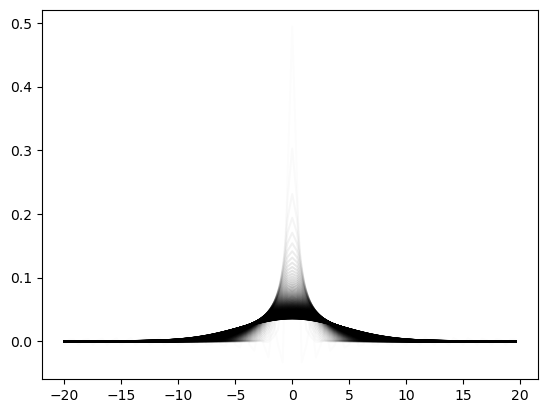

In [35]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots()
for ii in range(len(ϕA_list)):
    ax.plot(x, ϕA_list[ii], color='k', alpha = (ii + 1) / len(ϕA_list))

In [36]:
σ = np.zeros(len(ϕA_list))
for ii in range(len(ϕA_list)):
    μx = np.sum(x * ϕA_list[ii]) / ϕA_list[ii].sum()
    μxsq = np.sum(x**2 * ϕA_list[ii]) / ϕA_list[ii].sum()
    σ[ii] = np.sqrt(μxsq - μx**2)

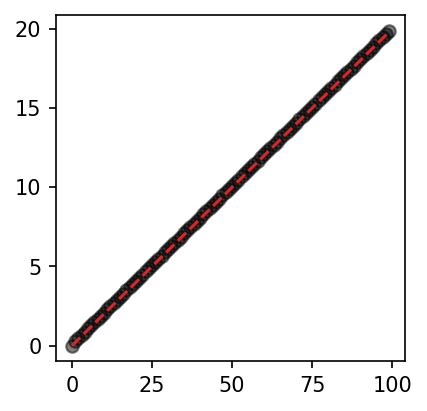

In [41]:
fig, ax = plt.subplots(dpi=150, figsize=(3,3))
ax.plot(t_list, σ**2, 'ko', alpha=0.5)
ax.plot(t_list, 2 * T * np.array(t_list), "C3--")